In [34]:
import csv
import numpy as np
import torch
import math
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from collections import defaultdict

Load the training data. These are the first two PCs of the G-vector for a small RNA.

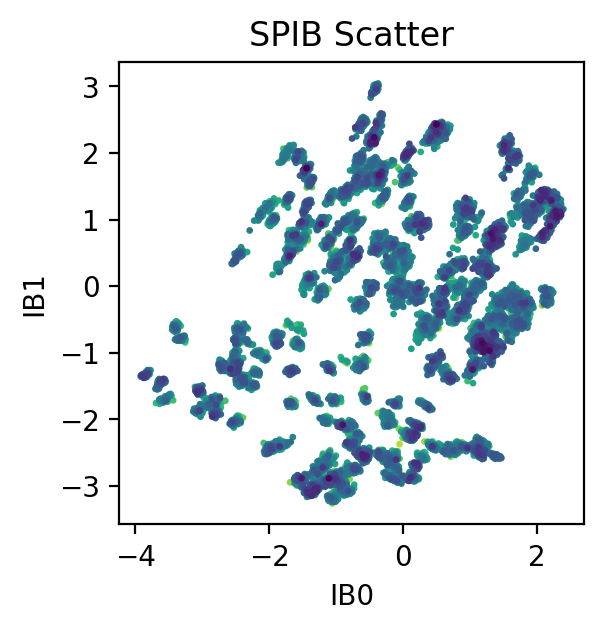

In [61]:
in_path = "../example/FMN_riboswitch_spib.csv"

pc1_vals = []
pc2_vals = []
temperature = []
potential = []
indices = []

# Load using csv module
with open(in_path, "r", newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        indices.append(row["index"])
        pc1_vals.append(float(row["ib0"]))
        pc2_vals.append(float(row["ib1"]))
        temperature.append(float(row['temperature']))
        potential.append(float(row['potential']))

# Make a scatter plot (no styles/colors specified)
plt.figure(dpi=200, figsize=(3,3));
pc1_vals = np.array(pc1_vals)
pc2_vals = np.array(pc2_vals)
potential = np.array(potential)
idxs = np.argsort(potential)[::-1]

plt.scatter(pc1_vals[idxs], pc2_vals[idxs], c=potential[idxs], s=2);
plt.xlabel("IB0");
plt.ylabel("IB1");
plt.title("SPIB Scatter");
plt.show();
plt.close();

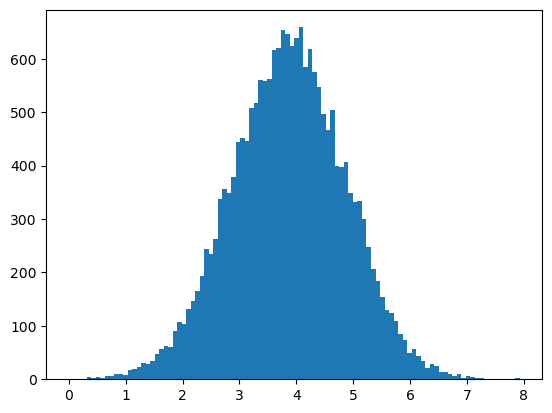

In [62]:
merged = np.array(potential)/np.array(temperature)
min_, sig = np.min(merged), np.std(merged)
plt.hist((merged-min_)/sig, bins=100);

In [63]:
np.corrcoef(potential, y=[temperature, merged])

array([[1.        , 0.15692089, 0.26149577],
       [0.15692089, 1.        , 0.99406906],
       [0.26149577, 0.99406906, 1.        ]])

Custom loader class.

In [40]:
class PCADataset:
    def __init__(self, csv_path):
        self.csv_path = Path(csv_path)
        self.data = []
        self._load()

    def _load(self):
        import csv
        import numpy as np

        with self.csv_path.open("r", newline="") as f:
            reader = csv.DictReader(f)
            rows = list(reader)  # <-- materialize iterator

        # First pass: collect temperature & potential
        T_ = np.array([float(r["temperature"]) for r in rows], dtype=float)
        potential_ = np.array([float(r["potential"]) for r in rows], dtype=float)

        # merged = potential_ / T_ # Experiment with standardizing potential energy and kinetic temperature into one variable
        merged = potential_ 
        min_, sig = np.min(merged), np.std(merged)
        if sig == 0:
            sig = 1.0  # avoid division by zero; or handle however you prefer

        # Second pass: build self.data
        for r, m in zip(rows, merged):
            index = r["index"]
            ib0 = float(r["ib0"])
            ib1 = float(r["ib1"])
            norm_val = (m - min_) / sig  # normalized potential/T

            self.data.append((index, ib0, ib1, norm_val))

    def __len__(self):
        return len(self.data)

    def _perturb(self, val, scale=5e-2):
        noise = scale * (2 * np.random.uniform() - 1)
        return val + noise

    def __getitem__(self, i):
        index, ib0, ib1, val = self.data[i]
        temps = np.array([[val]], dtype=float)       # (1, 1)
        coords = np.zeros((2, 2), dtype=float)       # (2, 2)
        coords[0, :] = [ib0, ib1]
        coords[1, :] = [self._perturb(val) for _ in range(2)]
        return index, torch.Tensor(temps), torch.Tensor(coords)


In [41]:
from tm.architectures.mlp import MLP
from tm.architectures.unet_1d import Unet1D

from tm.core.backbone import MLPBackbone, ConvBackbone
from tm.core.diffusion_process import VPDiffusion
from tm.core.prior import GlobalEquilibriumHarmonicPrior as Prior
from tm.core.diffusion_model import DiffusionTrainer, DiffusionSampler
from tm.core.utils import next_divisible_by_groups
from torch.utils.data import RandomSampler

In [42]:
train_loader = PCADataset(in_path)

In [43]:
full_shape = [1] + list(train_loader.__getitem__(0)[-1].shape)
full_shape

[1, 2, 2]

In [44]:
train_loader = PCADataset(in_path)

train_sampler = RandomSampler(train_loader)

Here I tested an MLP and my Franken-Unet. The Unet matches the prior better than the MLP while having a lower memory footprint -- though I did spend much more time optimizing the Unet compared to the MLP.

In [45]:
# model =MLP(dim=128, #recommend dim=128 if enough memory
#            num_resolutions=8,
#            mlp_hidden_mult=8,
#            dropout=0.05,
#            learned_variance=False,
#            self_condition=True,
#            resnet_block_groups=8,
#            learned_sinusoidal_cond=True,
#            channels=2
# )

# backbone = MLPBackbone(model=model,
#                        lr=1e-5,
#                        eval_mode="train",
#                        self_condition=True,
#                       )



model =Unet1D(dim=128, #recommend dim=128 if enough memory
           num_resolutions=4,
           self_condition=True,
           resnet_block_groups=8,
           learned_sinusoidal_cond=True,
           channels=2
)

# Backbone will automatically use CUDA if it is available -- otherwise CPU.
backbone = ConvBackbone(model=model,
                        data_shape=full_shape[-1],
                        target_shape=next_divisible_by_groups(full_shape[-1], 8),
                        num_dims=3,
                        lr=1e-5,
                        eval_mode="train",
                        self_condition=True,
                        interpolate=True
                      )

diffusion = VPDiffusion(num_diffusion_timesteps=100)

prior = Prior(shape=full_shape, channels_info={"coordinate": [0], "fluctuation": [1]})

Using device  cuda for TM


In [46]:
trainer = DiffusionTrainer(diffusion,
                           backbone,
                           train_loader,
                           prior,
                           model_dir='../example/models',
                           network_pred_type='noise',
                           train_sampler=train_sampler,
                           )

In [48]:
trainer.train(50, loss_type="l2", batch_size=512)

epoch: 0 | train loss: 1.608
epoch: 1 | train loss: 1.599
epoch: 2 | train loss: 1.605
epoch: 3 | train loss: 1.578
epoch: 4 | train loss: 1.593
epoch: 5 | train loss: 1.573
epoch: 6 | train loss: 1.575
epoch: 7 | train loss: 1.571
epoch: 8 | train loss: 1.565
epoch: 9 | train loss: 1.575
epoch: 10 | train loss: 1.576
epoch: 11 | train loss: 1.567
epoch: 12 | train loss: 1.572
epoch: 13 | train loss: 1.579
epoch: 14 | train loss: 1.559
epoch: 15 | train loss: 1.567
epoch: 16 | train loss: 1.564
epoch: 17 | train loss: 1.560
epoch: 18 | train loss: 1.564
epoch: 19 | train loss: 1.576
epoch: 20 | train loss: 1.570
epoch: 21 | train loss: 1.573
epoch: 22 | train loss: 1.554
epoch: 23 | train loss: 1.567
epoch: 24 | train loss: 1.558
epoch: 25 | train loss: 1.564
epoch: 26 | train loss: 1.552
epoch: 27 | train loss: 1.565
epoch: 28 | train loss: 1.563
epoch: 29 | train loss: 1.566
epoch: 30 | train loss: 1.564
epoch: 31 | train loss: 1.562
epoch: 32 | train loss: 1.553
epoch: 33 | train lo

In [49]:
backbone.load_model('../example/models', epoch='latest')

load_state using device choice: cuda


In [50]:
diffusion = VPDiffusion(num_diffusion_timesteps=10) # time mesh does not have to be the same as during training
sampler = DiffusionSampler(diffusion, backbone, train_loader, prior, network_pred_type='noise')

Simple consistency test to verify that the model is working properly. Push the training data forward through the diffusion process to get prior (latent) representations. Verify that they are gaussian distributed (or at least close to). Then take the prior reps and use them as initial conditions for the generative process. If everything is working properly, then we should recover the training distribution. 

In [51]:
# Training data --> Prior reps (deterministic forward process)

output_dict = defaultdict(list)
direction = 'forward'
T = 1

# If OOM error reduce batch size
data_loader = torch.utils.data.DataLoader(train_loader, batch_size=512, shuffle=False, pin_memory=True)

for batch_index, (index, temperatures, b) in enumerate(tqdm(data_loader, desc="Processing batches")):
    # print(index)
    batch_size = b.size(0)
    for index_ in index:
        if index_ not in output_dict.keys():
            output_dict[index_] = {'target': [], 'prior': [], 'delta_log_pq': [], 'log_p': [], 'log_q': []}
    # else:
    #     output_dict[index] = {'target': [], 'prior': [], 'delta_log_pq': [], 'log_p': [], 'log_q': []}

    output_dict_ = sampler.sample_batch(x0=b, 
                                        mode=direction, 
                                        eta=0, # 0 is ODE, 1 is SDE
                                        gamma=0, # control some of the channels (0 is no control)
                                        batch_size=batch_size,
                                        temperatures=T, # can be scalar of vector (len is num samples)
                                        likelihood=True,
                                        control_dict={}, 
                                        pred_type='noise')

    for i_, index_ in enumerate(index):
        for k,v in output_dict_.items():
            output_dict[index_][k] = output_dict_[k][i_]

Processing batches: 100%|███████████████████████████████████| 40/40 [00:43<00:00,  1.09s/it]


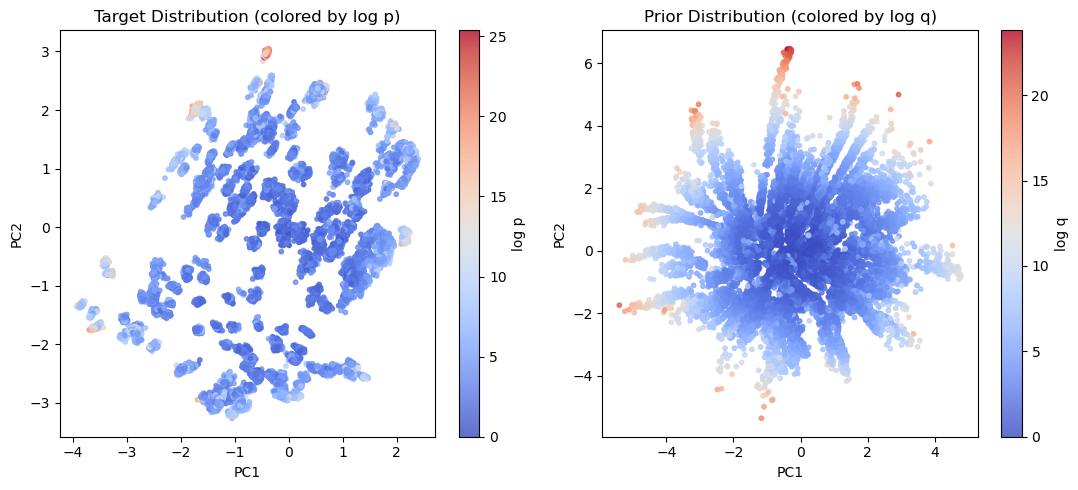

In [52]:
targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
    if entry:
        try:
            targets.append(entry["target"][0])  # 0 - coordinates, 1 - temperatures
            priors.append(entry["prior"][0])
            logp.append(float(entry["log_p"]))
            logq.append(float(entry["log_q"]))
        except:
            None

logp = -np.array(logp)
logq = -np.array(logq)

logp -= min(logp)
logq -= min(logq)

targets, priors = np.array(targets), np.array(priors)
logp, logq = np.array(logp), np.array(logq)

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

sc1 = axes[0].scatter(targets[:, 0], targets[:, 1], c=logp, cmap='coolwarm', s=10, alpha=0.8)
axes[0].set_title("Target Distribution (colored by log p)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
plt.colorbar(sc1, ax=axes[0], label='log p')

sc2 = axes[1].scatter(priors[:, 0], priors[:, 1], c=logq, cmap='coolwarm', s=10, alpha=0.8)
axes[1].set_title("Prior Distribution (colored by log q)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
plt.colorbar(sc2, ax=axes[1], label='log q')

plt.tight_layout()
plt.show()


Save the prior reps.

In [64]:
targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
        try:
            targets.append(entry["target"][None,:,:])  # 0 - coordinates, 1 - temperatures
            priors.append(entry["prior"][None,:,:])
            logp.append(float(entry["log_p"]))
            logq.append(float(entry["log_q"]))
        except:
            None
targets_ = np.array(targets).squeeze()
priors_ = np.array(priors).squeeze()


In [65]:
np.save('prior_endpoints.npy', priors_)

In [66]:
priors_ = np.load('prior_endpoints.npy')

In [67]:
# Prior reps --> Training data (deterministic reverse process)

# Parameters
# for T in np.linspace(0.1,10,0.1):

batch_size = 512
N = priors_.shape[0]     # or: N = priors_.shape[0]
T = 1
direction = "reverse"

output_dict = {}  # will hold N unique indices: 0..N-1

# Make sure N matches priors_
N = priors_.shape[0]
num_batches = math.ceil(N / batch_size)

for b_ix in tqdm(range(num_batches)):
    start = b_ix * batch_size
    end   = min(start + batch_size, N)
    bs    = end - start
    if bs <= 0:
        break

    # Slice this batch of prior points
    b_np = priors_[start:end]                 # shape (bs, ...)
    # If priors_ is numpy; if it's already torch, you can skip as_tensor
    b = torch.as_tensor(b_np, dtype=torch.float32)  # .to(device) if needed

    # Run sampler on this batch (push prior points backward)
    output_dict_batch = sampler.sample_batch(
        x0=b,
        mode=direction,
        eta=0,                  # 0 = ODE, 1 = SDE (if implemented inside)
        gamma=0,                # no control
        batch_size=bs,
        temperatures=T,         # scalar or vector; same as before
        likelihood=True,
        control_dict={},
        network_pred_type="noise",   # NOTE: use network_pred_type, not pred_type
    )

    # Store results with unique global indices
    # Assumes output_dict_batch fields have shape (bs, ...)
    for i in range(bs):
        idx = start + i
        output_dict[idx] = {
            "target":       output_dict_batch["target"][i],
            "prior":        output_dict_batch["prior"][i],
            "delta_log_pq": output_dict_batch["delta_log_pq"][i],
            "log_p":        output_dict_batch["log_p"][i],
            "log_q":        output_dict_batch["log_q"][i],
        }


100%|███████████████████████████████████████████████████████| 40/40 [00:42<00:00,  1.07s/it]


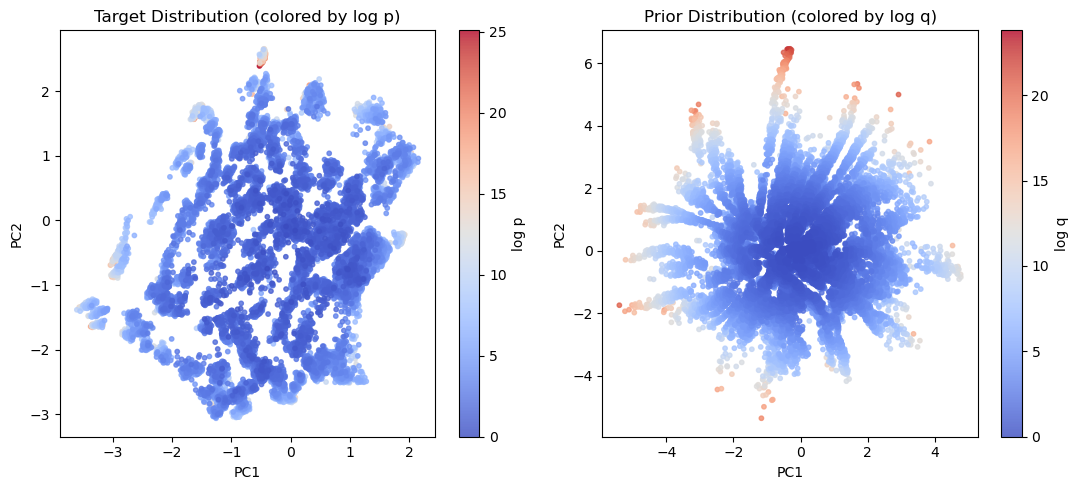

In [68]:
targets, priors = [], []
logp, logq = [], []

for entry in output_dict.values():
    try:
        targets.append(entry["target"][0])  # coordinate row
        priors.append(entry["prior"][0])
        logp.append(float(entry["log_p"]))
        logq.append(float(entry["log_q"]))
    except:
        None

logp = -np.array(logp)
logq = -np.array(logq)

logp -= min(logp)
logq -= min(logq)

targets, priors = np.array(targets), np.array(priors)
logp, logq = np.array(logp), np.array(logq)

idxs = np.argsort(logp)[::-1]

fig, axes = plt.subplots(1, 2, figsize=(11, 5))

sc1 = axes[0].scatter(targets[idxs, 0], targets[idxs, 1], c=logp[idxs], cmap='coolwarm', s=10, alpha=0.8)
axes[0].set_title("Target Distribution (colored by log p)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
plt.colorbar(sc1, ax=axes[0], label='log p')

idxs = np.argsort(logq)[::-1]

sc2 = axes[1].scatter(priors[idxs, 0], priors[idxs, 1], c=logq[idxs], cmap='coolwarm', s=10, alpha=0.8)
axes[1].set_title("Prior Distribution (colored by log q)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
plt.colorbar(sc2, ax=axes[1], label='log q')

plt.tight_layout()
plt.show()


The code below enables the user to generate samples from the training distribution by sampling from the prior.

In [94]:
import math
from tqdm import tqdm
import torch
import numpy as np

# Parameters
dT = 0.05
T_range = np.arange(dT, 7, dT)

logZ_T = {}
outputs_T = {}

for T in tqdm(T_range):

    batch_size = 1000
    N = 10000
    direction = "reverse"
    
    output_dict = {}  # will hold N unique indices: 0..N-1
    
    # Make sure N matches priors_
    num_batches = math.ceil(N / batch_size)
    
    for b_ix in range(num_batches):
        start = b_ix * batch_size
        end   = min(start + batch_size, N)
        bs    = end - start
        if bs <= 0:
            break
    
        b = prior.sample(batch_size=bs, temperatures=T)
    
        # Run sampler on this batch (push prior points backward)
        output_dict_batch = sampler.sample_batch(
            x0=b,
            mode=direction,
            eta=0,                  # 0 = ODE, 1 = SDE (if implemented inside)
            gamma=1,                # no control
            batch_size=bs,
            temperatures=T,         # scalar or vector; same as before
            likelihood=True,
            control_dict={1:T},
            network_pred_type="noise",   # NOTE: use network_pred_type, not pred_type
        )
    
        # Store results with unique global indices
        # Assumes output_dict_batch fields have shape (bs, ...)
        for i in range(bs):
            idx = start + i
            delta_log_pq = output_dict_batch["delta_log_pq"][i]
            logq = output_dict_batch["log_q"][i]
            output_dict[idx] = {
                "target":       output_dict_batch["target"][i],
                "prior":        output_dict_batch["prior"][i],
                "delta_log_pq": output_dict_batch["delta_log_pq"][i],
                "log_p":        logq + delta_log_pq,
                "log_q":        output_dict_batch["log_q"][i],
            }
    
    logps = torch.stack([torch.as_tensor(d['log_p']) for d in output_dict.values()])  # shape (N, ...)
    logZ = torch.logsumexp(logps, dim=0)
    # Z = torch.exp(logZ)
    logZ_T[T] = logZ
    outputs_T[T] = output_dict


100%|███████████████████████████████████████████████████| 139/139 [1:03:54<00:00, 27.58s/it]


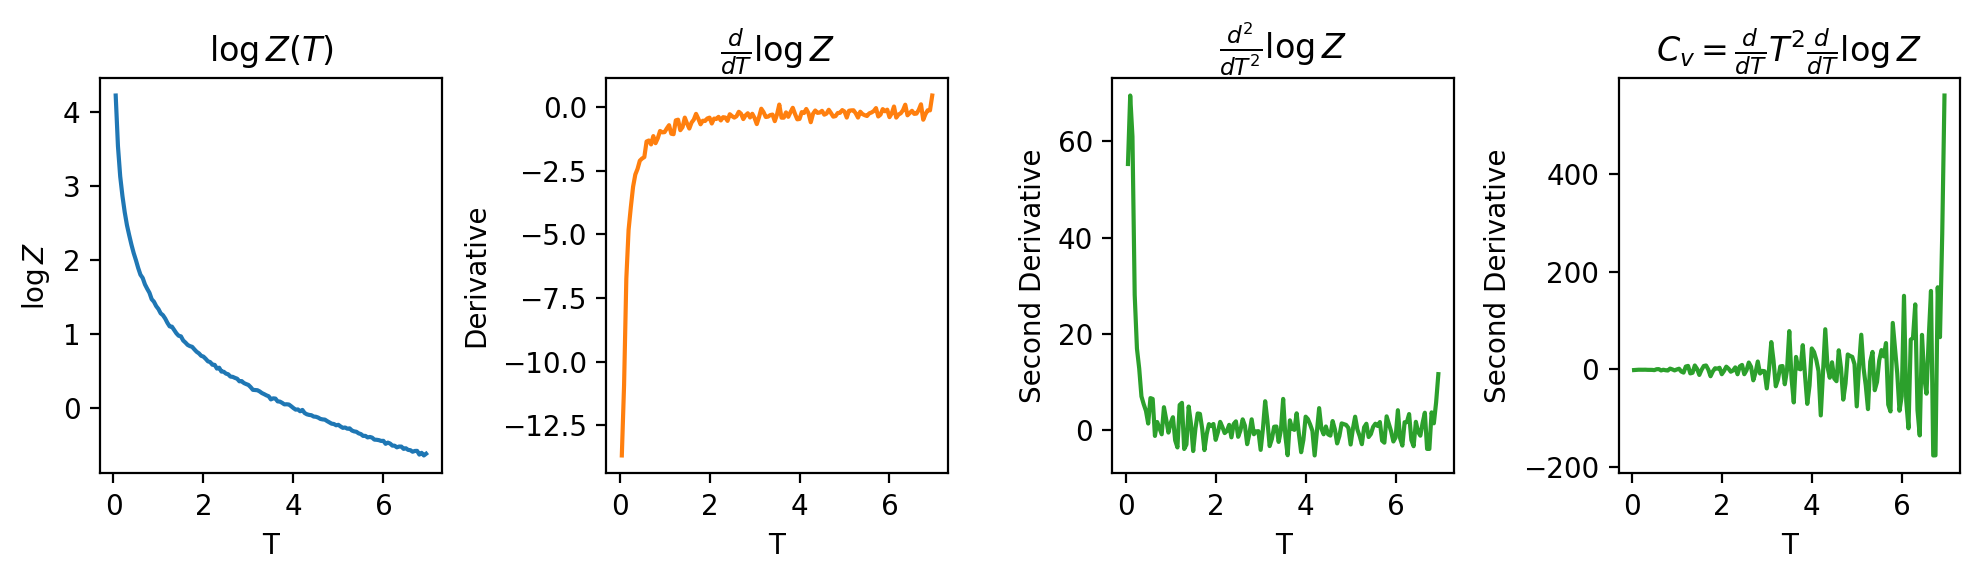

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Example data
T = np.array([k for k in logZ_T.keys()])
y = np.array([v for v in logZ_T.values()])

# First derivative: d(logZ)/dT
dlnZ_dT = np.gradient(y, T)

# Second derivative: d²(logZ)/dT² (heat capacity–like)
d2lnZ_dT2 = np.gradient(dlnZ_dT, T)

cv = np.gradient(dlnZ_dT*T**2, T)


# Create figure with 3 subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 3), dpi=200)

axes[0].plot(T, y, color='C0')
axes[0].set_title(r'$\log Z(T)$')
axes[0].set_xlabel('T')
axes[0].set_ylabel(r'$\log Z$')

axes[1].plot(T, dlnZ_dT, color='C1')
axes[1].set_title(r'$\frac{d}{dT} \log Z$')
axes[1].set_xlabel('T')
axes[1].set_ylabel('Derivative')

axes[2].plot(T, d2lnZ_dT2, color='C2')
axes[2].set_title(r'$\frac{d^2}{dT^2} \log Z$')
axes[2].set_xlabel('T')
axes[2].set_ylabel('Second Derivative')

axes[3].plot(T, cv, color='C2')
axes[3].set_title(r'$C_v = \frac{d}{dT} T^2 \frac{d}{dT} \log Z$')
axes[3].set_xlabel('T')
axes[3].set_ylabel('Second Derivative')

plt.tight_layout()
plt.show()


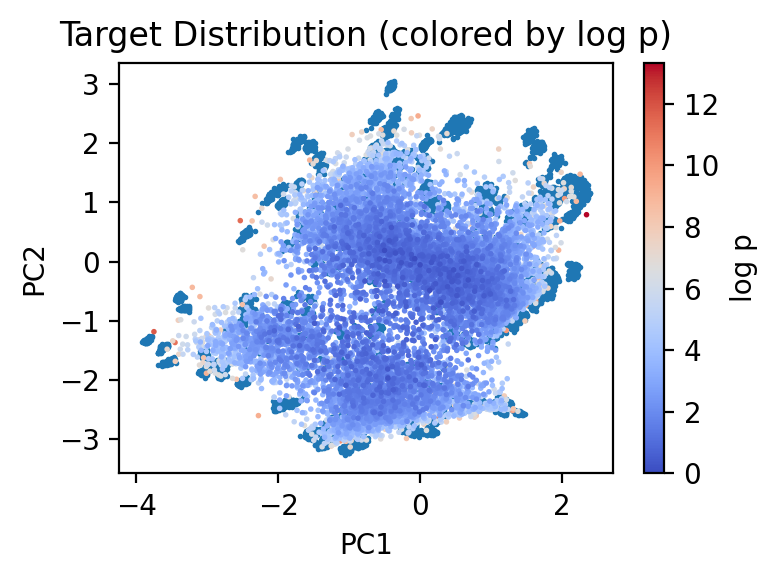

In [93]:
targets, priors = [], []
logp, logq = [], []

T = 2

for entry in outputs_T[T].values():
    try:
        targets.append(entry["target"][0])  # coordinate row
        priors.append(entry["prior"][0])
        logp.append(float(entry["log_p"]))
        logq.append(float(entry["log_q"]))
    except:
        None

logp = -np.array(logp)
logq = -np.array(logq)

logp -= min(logp)
logq -= min(logq)

targets, priors = np.array(targets), np.array(priors)
logp, logq = np.array(logp), np.array(logq)

idxs = np.argsort(logp)[::-1]

fig, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=200)
axes = [axes]
sc1 = axes[0].scatter(targets[idxs, 0], targets[idxs, 1], c=logp[idxs], cmap='coolwarm', s=1, alpha=1)
axes[0].scatter(pc1_vals, pc2_vals, s=1, zorder=-1)
axes[0].set_title("Target Distribution (colored by log p)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
plt.colorbar(sc1, ax=axes[0], label='log p')

idxs = np.argsort(logq)[::-1]

# sc2 = axes[1].scatter(priors[idxs, 0], priors[idxs, 1], c=logq[idxs], cmap='coolwarm', s=10, alpha=0.8)
# axes[1].set_title("Prior Distribution (colored by log q)")
# axes[1].set_xlabel("PC1")
# axes[1].set_ylabel("PC2")
# plt.colorbar(sc2, ax=axes[1], label='log q')

# axes[0].set_xlim(-2,2)
# axes[0].set_ylim(-2,2)

plt.tight_layout()
plt.show()


/tmp/ipykernel_766805/1005835534.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")
/tmp/ipykernel_766805/1005835534.py:56: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


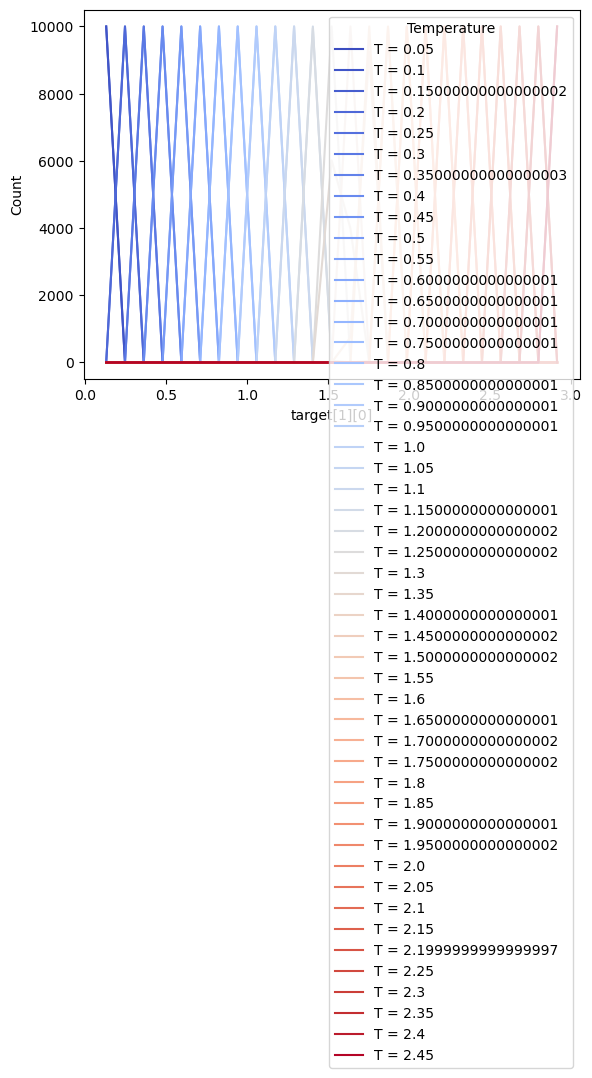

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors

# Assume T_range and outputs_T already exist
# 1) Gather all values to define a common binning
all_vals = []

for T in T_range:
    for entry in outputs_T[T].values():
        try:
            # entry["target"][1] is the coordinate row you care about
            all_vals.append(entry["target"][1][0])  # x-coordinate
        except Exception:
            continue

all_vals = np.array(all_vals, dtype=float)
n_bins = 25
bins = np.linspace(all_vals.min(), all_vals.max(), n_bins + 1)  # 25 bins → 26 edges
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# 2) Set up coolwarm colormap interpolated over T_range
T_min, T_max = min(T_range), max(T_range)
norm = colors.Normalize(vmin=T_min, vmax=T_max)
cmap = cm.get_cmap("coolwarm")

plt.figure()

# 3) Loop over T, compute histogram with np.histogram, plot with plt.plot
for T in T_range:
    targets = []

    for entry in outputs_T[T].values():
        try:
            targets.append(entry["target"][1][0])  # x-coordinate
        except Exception:
            continue

    if len(targets) == 0:
        continue

    targets = np.array(targets, dtype=float)

    # np.histogram (not plt.hist) to get counts per bin
    counts, _ = np.histogram(targets, bins=bins)

    # Interpolated color from coolwarm based on T
    color = cmap(norm(T))

    # Line plot of the histogram
    plt.plot(bin_centers, counts, label=f"T = {T}", color=color)

plt.xlabel("target[1][0]")
plt.ylabel("Count")
plt.legend(title="Temperature")
plt.tight_layout()
plt.show()

